<img src="https://www.companieshistory.com/wp-content/uploads/2013/07/ConocoPhillips.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 5px;" />

# Detection before failure 

**Abhay Vashist, Adam Johnston, Rajan Kapoor, Yung-Hsin Tung**




### The Challenge
**The goal of this challenge will be to predict surface and down-hole failures using the data set provided. This information can be used to send crews out to a well location to fix equipment on the surface or send a workover rig to the well to pull down-hole equipment and address the failure.**



In [35]:
%matplotlib inline
import pandas as pd
import numpy as np 
import seaborn as sns 
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# we will have to play with the error to figure out which meter is best to train the data
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [36]:
# importing the data
test_df = pd.read_csv('equipfails/equip_failures_test_set.csv')
train_df = pd.read_csv('equipfails/equip_failures_training_set.csv')
test_df.shape

(16001, 171)

Replace string `'na'` with `np.nan`

In [37]:
train_df = train_df.replace('na', np.nan)
train_df_na = (train_df.isnull().sum()/len(train_df))*100
train_df_na = train_df_na.drop(train_df_na[train_df_na == 0].index).sort_values(ascending=False)

To get an idea of how the missing values are characterized, we sum the number in each column and divide by the number of rows to get the percentage of missing values for each feature.

(Text(0.5, 0, 'feature id'), Text(0.5, 1.0, 'Missing Value Characterization'))

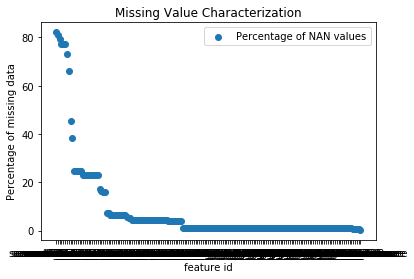

In [38]:

train_df_na = pd.DataFrame(train_df_na)
train_df_na.columns = ['Percentage of NAN values']
plt.scatter(x = train_df_na.index, y = train_df_na['Percentage of NAN values'])
plt.legend(train_df_na.columns), plt.ylabel('Percentage of missing data')
plt.xlabel('feature id'), plt.title('Missing Value Characterization')


From the above plot, we see three distinct clusters that we have marked in the plot below. We identified these three possible threshold values that can be used to remove the columns from the data set (shown below).

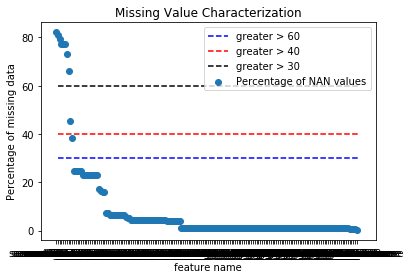

In [42]:
plt.scatter(x = train_df_na.index, y = train_df_na['Percentage of NAN values'])
plt.ylabel('Percentage of missing data')
plt.xlabel('feature name'), plt.title('Missing Value Characterization')
xs = np.linspace(1,len(train_df_na['Percentage of NAN values'])+1,len(train_df_na['Percentage of NAN values'])+1)
horiz_line_data = np.array([30 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'b--') 
horiz_line_data = np.array([40 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([60 for i in range(len(xs))])
plt.plot(xs, horiz_line_data, 'k--') 
plt.legend(['greater > 60','greater > 40' ,'greater > 30', (train_df_na.columns)[0]], loc  = 1)

### Pre-Processing

Our main focus in pre-processing is to handle the missing values. There are two tuneable parameters for this process, the threshold for removing a column completely as mentioned above, and the replacement method. The threshold is the percentage of NaN values such that, if a column contains more than that threshold of NaN values, we consider the entire feature to be invalid and remove it from the dataset. The method of replacement is then used to replace the remaining NaN values. We chose to explore the following parameters using a grid search.

| NaN Threshold | Replacement Method |
|---------------|--------------------|
| 20%           | Mean               |
| 40%           | Median             |
| 60%           | Mode               |
| 100%          |                    |

For defaults, we chose 40% NaN threshold and mean replacement method so that we could do model exploration and decide on the model. After chosing a model, we will be able to do the grid search to select the best pre-processing parameters

In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Create pre-processing fn with defaults
scaler = preprocessing.MinMaxScaler()
train_df.replace('na', np.nan, inplace=True)
scaler.fit(train_df.drop('id', axis=1).drop('target', axis=1))
def preprocess_data(dataset, scaler, nan_thresh=0.4, replace='mean'):
    dataset.replace('na', np.nan, inplace=True)
    df = dataset.drop('id', axis=1)
    ids = dataset['id']
    X = pd.DataFrame(
        scaler.transform(df), 
        columns=[df.columns])
    X.insert(0, 'id', ids)
    for column in X.columns:
        if X[column][X[column] == np.nan].sum() > (60000 * nan_thresh):
            X.drop(column, inplace=True)
    if replace == 'mean':
        X.fillna(X.mean(), inplace=True)
    elif replace == 'median':
        X.fillna(X.median(), inplace=True)
    elif replace == 'mode':
        X.fillna(X.mode(), inplace=True)
    elif replace == 'zero':
        X.fillna(0, inplace=True)
    return X

### Model Exploration

First, we assess the performance of an Support Vector Classifier.

In [44]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(train_X, train_y) 
val_predictions = clf.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print(val_mae)

0.016777777777777777


Next, we assess the performance of a decision tree model. We used both a classifier and a regressor.

In [45]:
descision_tree_model = RandomForestRegressor(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X).astype(int)
val_mae = mean_absolute_error(val_predictions, val_y)
print('Regressor Acc:', 1-(val_mae))

C:\Users\ajohn\Miniconda3\envs\datathon\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Regressor Acc: 0.9865555555555555


In [46]:
descision_tree_model = tree.DecisionTreeClassifier(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print('Classifier Acc:', 1-(val_mae))

Classifier Acc: 0.9871666666666666


The Decision Tree Classifier algorithm when trained over 0.8 percent of the train was able to achieve an accuracy of over 98%. The Tree performs better than SVM before any adjustment. Decision Tree algorithm only trains based on the empirical and does not try to optimize the margin between the two different classes. To take margin to take into account we implemented a Decision Tree Regressor algorithm. In theory, the regression tree algorithm provides control over the generalization error. In practice, we found that there was no difference in the error between the Classifier and Regressor. Therefore, we chose to go with a Decision Tree Classifier model.

### Pre-Processing Grid Search

After selecting a model, we applied a grid search on the pre-processing parameters to decide the best pre-processing method

In [47]:
def grid_search_heatmap(grid_search_results, params, labels):
    param1, param2 = params
    label1, label2 = labels
    param_index = grid_search_results['params']
    mean_test_scores = grid_search_results['mean_test_score']
    cv_data = {
        param1: [],
        param2: [],
        'mean_test_score': []
    }
    for i in range(len(param_index)):
        cv_data[param1].append(param_index[i][param1])
        cv_data[param2].append(param_index[i][param2])
        cv_data['mean_test_score'].append(mean_test_scores[i])
    grid_search_results = pd.DataFrame(cv_data)
    p1 = grid_search_results[param1].unique()
    p2 = grid_search_results[param2].unique()
    grid_search = np.zeros((len(p1), len(p2)))
    for i in range(len(p1)):
        for j in range(len(p2)):
            grid_search[i][j] = grid_search_results[
                (grid_search_results[param1] == p1[i]) & 
                (grid_search_results[param2] == p2[j])
            ]['mean_test_score']
    fig, ax = plt.subplots()
    cax = ax.matshow(grid_search, cmap='hot')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+[str(p) for p in p1])
    ax.set_yticklabels(['']+[str(p) for p in p2])
    ax.set_xlabel(label1)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(label2)

C:\Users\ajohn\Miniconda3\envs\datathon\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ajohn\Miniconda3\envs\datathon\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ajohn\Miniconda3\envs\datathon\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ajohn\Miniconda3\envs\datathon\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ajohn\M

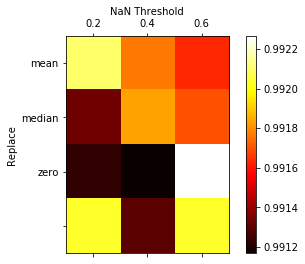

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# Pre-processing grid
preproc_params = {
    'nan_thresh': [0.2, 0.4, 0.6, 1.0],
    'replace': ['mean', 'median', 'zero']
}
preproc_grid_results = {
    'params': [],
    'mean_test_score': []
}
X_preproc = np.empty((len(preproc_params['nan_thresh']), len(preproc_params['replace'])))
for i in range(0, len(preproc_params['nan_thresh'])):
    for j in range(0, len(preproc_params['replace'])):
        X = preprocess_data(train_df.drop('target', axis=1), 
                            scaler, 
                            preproc_params['nan_thresh'][i],
                            preproc_params['replace'][j])
        y = train_df['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        preproc_grid_results['params'].append({
            'nan_thresh': preproc_params['nan_thresh'][i],
            'replace': preproc_params['replace'][j]
        })
        preproc_grid_results['mean_test_score'].append(metrics.accuracy_score(y_test, y_pred))
grid_search_heatmap(preproc_grid_results, ['nan_thresh', 'replace'], ['NaN Threshold', 'Replace'])

### Parameter Grid Search

After deciding on the best pre-processing method, we apply a grid search across two parameters of the Random Forest model.

| Number of Estimators | Max Features       |
|----------------------|--------------------|
| 50                   | 10                 |
| 100                  | 50                 |
| 300                  | auto               |

C:\Users\ajohn\Miniconda3\envs\datathon\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


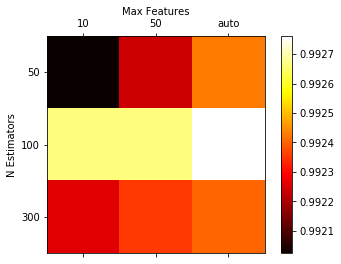

In [51]:
X = preprocess_data(train_df.drop('target', axis=1), scaler, nan_thresh=0.6, replace='zero')
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators=100)
params = {'n_estimators': [50, 100, 300], 'max_features': [10, 50, 'auto']}
clf = GridSearchCV(rf, params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
grid_search_heatmap(clf.cv_results_, ['max_features', 'n_estimators'], ['Max Features', 'N Estimators'])

### Gradient Boosting

Now that we have pre-processing method in place and a well-tuned model, we can apply gradient boosting to further increase our accuracy

In [19]:
from xgboost import XGBClassifier
my_model = XGBClassifier()
my_model.fit(train_X, train_y, 
             early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)],
             verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
my_model.score(val_X, val_y)
test_preds = my_model.predict(test_df_needed)

We find that the gradient boosting did not have a noticable effect, which is likely because the initial model was already performing so well

In [21]:
output = pd.DataFrame({'Id': test_df['id'],
                       'target': test_preds})
output.to_csv('submission_2.csv', index=False)

#### Now We are performing PCA on the data

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=min(train_X.shape))
trainx_pca = pca.fit_transform(train_X)

Text(0.5, 1.0, 'Singular')

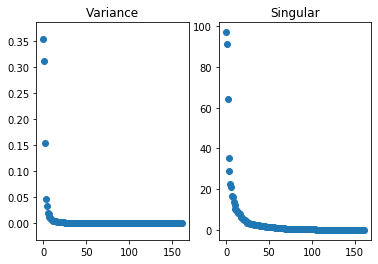

In [68]:
_, ax = plt.subplots(1, 2)
ax[0].scatter(y = pca.explained_variance_ratio_, x = range(0,len(pca.explained_variance_ratio_)) )
ax[0].set_title('Variance')
ax[1].scatter(y = pca.singular_values_, x = range(0,len(pca.singular_values_)) )
ax[1].set_title('Singular')

We are performing the PCA in order to determine the key faction and reduce the dimensionality of the model.

In [70]:
pca = PCA(n_components = 1*5)
trainx_pca = pca.fit_transform(train_X)

In [71]:
for i in range(0,5):
    k = np.amax(pca.components_[:][i])
    print(np.where(pca.components_ == k))

(array([0], dtype=int64), array([82], dtype=int64))
(array([1], dtype=int64), array([1], dtype=int64))
(array([2], dtype=int64), array([147], dtype=int64))
(array([3], dtype=int64), array([141], dtype=int64))
(array([4], dtype=int64), array([71], dtype=int64))


In [73]:
matrix = pca.components_ >= 0
value = matrix[:][0]+matrix[:][1]+matrix[:][2]+matrix[:][3]

x_false = x[value== False]

postpac_data = np.delete(train_X,x[value== False],axis=1)
postpac_test =  np.delete(val_X,x[value== False],axis=1)
pca2 = PCA(n_components = 15)
pca2.fit_transform(postpac_data)

plt.scatter(y = pca2.explained_variance_ratio_, x = range(0,len(pca2.explained_variance_ratio_)) )

NameError: name 'x' is not defined

In [180]:
pca2 = PCA(n_components = 6)
pca2_train = pca2.fit_transform(postpac_data)
pca2_val = pca2.transform(postpac_test)


descision_tree_model = RandomForestRegressor(random_state=1)
    # Fit Model
descision_tree_model.fit(pca2_train, train_y)
# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(pca2_val).astype(int)
val_mae = mean_absolute_error(val_predictions, val_y)
print(val_mae)


/Users/abhay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.016277777777777776


In [175]:
pca2_train.shape

(42000, 6)

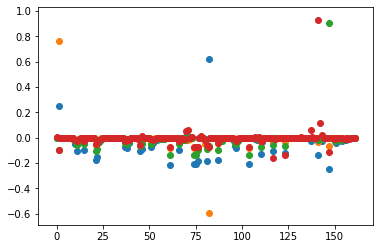

In [139]:
for i in range(0,4):
    plt.scatter(y = pca.components_[:][i], x = range(0,len(pca.components_[:][i])))

#### Creating a Training and validation set to train the model base of the reliable feature 

Text(0, 0.5, 'Count')

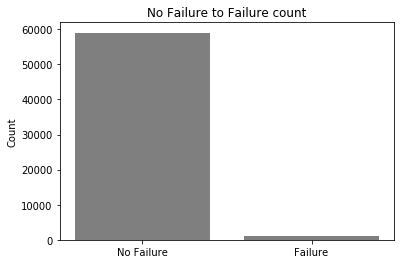

In [43]:
X = Data_train[Data_train.columns[Data_train.columns != 'target']]
X = preprocessing.normalize(X)
y = Data_train['target']
train_X, val_X, train_y, val_y  = train_test_split(X, y, test_size=0.30, random_state=42)
count = np.array([(y[y==0]).count(),(y[y==1]).count()])
objects = ('No Failure', 'Failure')
plt.bar(np.arange(len(objects)), count, align='center', alpha=0.5, color='black')
plt.title('No Failure to Failure count'),plt.xticks(np.arange(len(objects)), objects)
plt.ylabel('Count')